## Full Tile Prediction

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
import datetime
import math

import comet_ml
from comet_ml import Experiment
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

from rasterio.windows import Window
from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon, Point
import geopandas as gpd

Using TensorFlow backend.


In [16]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [4]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [5]:
def make_all_pixels(tile):
    points = []
    l8_points = []
    x = np.arange(0, 5000, 1)
    y = np.arange(0, 5000, 1)
    for row in y:
        for col in x:
            point = (row, col)
            points.append(point)
    for point in points:
        l8_points.append((point, tile))
    return l8_points

In [6]:
def delete_bad_tiles(l8_data, lc_label, canopy_label, pixels, tile_size, buffer_pix=None):
    buffer = math.floor(tile_size / 2)
    cloud_list = [-999999] # nothing # high confidence cloud [224] # full list [72, 80, 96, 130, 132, 136, 160, 224]
    new_pixels = []
    l8_proj = Proj(l8_data['028012'][0].crs)
    lc_proj = Proj(lc_label.crs)
    canopy_proj = Proj(canopy_label.crs)
    counter = 0
    center_index = math.floor(tile_size / 2)
    l8_mask = [1] * len(pixels)
    for idx, pixel in enumerate(pixels):
        r, c = pixel[0]
        dataset_index = pixel[1]
        tiles_to_read = l8_data[dataset_index]
        tiles_read = util.read_windows(tiles_to_read, c ,r, buffer, tile_size)
        (x, y) = l8_data[dataset_index][0].xy(r, c) 
        # convert the point we're sampling from to the same projection as the label dataset if necessary
        #if l8_proj != lc_proj:
            #lc_x,lc_y = transform(l8_proj,lc_proj,x,y)
        lc_x,lc_y = x,y
        # these are broken and not working for some reason because pyproj doesn't understand the canopy projection
        #if l8_proj != canopy_proj:
        #    canopy_x, canopy_y = transform(l8_proj,canopy_proj,x,y)
        # but luckily there only a couple cm different so it shouldn't matter
        canopy_x = x
        canopy_y = y
        # reference gps in label_image
        lc_row, lc_col = lc_label.index(lc_x,lc_y)
 
        lc_data = lc_label.read(1, window=Window(lc_col-buffer, lc_row-buffer, tile_size, tile_size))
        canopy_row, canopy_col = canopy_label.index(canopy_x,canopy_y)
        canopy_data = canopy_label.read(1, window=Window(canopy_col-buffer, canopy_row-buffer, tile_size, tile_size))
        flag = True
        # this used to eliminate pixels with only a single value to balance the FCN but now we don't want that
        #if len(np.unique(lc_data)) == 1 and 11 in lc_data and tile_size != 1:
        #    flag = False
        
        if 0 in lc_data or np.nan in lc_data or np.nan in canopy_data or 255 in canopy_data or canopy_data.shape != (tile_size, tile_size):
            flag = False
        #counter += 1
        
        if flag:
            # TODO this can very likely be optimized and doesn't need to be a for loop
            for tile in tiles_read:
                if np.isnan(tile).any() == True or -9999 in tile or tile.size == 0 or np.amax(tile) == 0 or np.isin(tile[7,:,:], cloud_list).any() or tile.shape != (l8_data[dataset_index][0].count, tile_size, tile_size):
                    flag = False
                    break
                
        if buffer_pix and flag:
            # check all surrounding pixels with a radius of buffer_pix and if any are a different value then 
            # flag it and don't include it in the output
            lc_data_merged = np.vectorize(util.class_to_index.get)(lc_data)
            if len(np.unique(lc_data_merged[center_index-buffer_pix:center_index+buffer_pix+1, center_index-buffer_pix:center_index+buffer_pix+1])) != 1:
                flag = False
        
        if flag:
            new_pixels.append(pixel)
        else:
            l8_mask[idx] = 0
            
        if counter % 1000 == 0:
            #print(counter)
            pass
    return(new_pixels, l8_mask)

### Begin Image Processing and Classification

In [7]:
tile = '028011'
model = 'rcnn'
year = '1989'
img_name = model + '_' + tile + '_' + year
img_name

'rcnn_028011_1989'

In [12]:
tiles = {}
landsat_datasets = {}
if year == '2011':
    tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
    tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
    tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']
elif year == '2000':
    tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
    tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
    tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']
elif year == '1989':
    tiles['028012'] = ['19881205', '19890311', '19890412', '19891005', '19891021']
    tiles['029011'] = ['19890311', '19890428', '19890615', '19891005', '19891021']
    tiles['028011'] = ['19890311', '19890412', '19890615', '19891005', '19891021']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [13]:
all_px = make_all_pixels(tile)
all_px[:10]

[((0, 0), '028011'),
 ((0, 1), '028011'),
 ((0, 2), '028011'),
 ((0, 3), '028011'),
 ((0, 4), '028011'),
 ((0, 5), '028011'),
 ((0, 6), '028011'),
 ((0, 7), '028011'),
 ((0, 8), '028011'),
 ((0, 9), '028011')]

In [14]:
landsat_datasets

{'028011': [<open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined19890311.tif' mode='r'>,
  <open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined19890412.tif' mode='r'>,
  <open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined19890615.tif' mode='r'>,
  <open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined19891005.tif' mode='r'>,
  <open DatasetReader name='/deep_data/recurrent_data/tile028011/combined/combined19891021.tif' mode='r'>],
 '028012': [<open DatasetReader name='/deep_data/recurrent_data/tile028012/combined/combined19881205.tif' mode='r'>,
  <open DatasetReader name='/deep_data/recurrent_data/tile028012/combined/combined19890311.tif' mode='r'>,
  <open DatasetReader name='/deep_data/recurrent_data/tile028012/combined/combined19890412.tif' mode='r'>,
  <open DatasetReader name='/deep_data/recurrent_data/tile028012/combined/combined19891005.tif' mode='r'>,
  <open DatasetR

In [15]:
tile_size = 9
print(datetime.datetime.now())
clean_px, l8_mask = delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, all_px, tile_size)
print(datetime.datetime.now())

2020-07-14 04:54:05.010566
2020-07-14 15:57:10.630539


In [16]:
np.unique(l8_mask, return_counts=True)

(array([0, 1]), array([ 4521997, 20478003]))

In [17]:
model = keras.models.load_model('model_search/rcnn--fullval_keras_tests.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [18]:
class_count = 6
print(datetime.datetime.now())
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
print(datetime.datetime.now())

2020-07-14 15:57:19.352703
2020-07-14 15:57:19.353082


In [19]:
len(clean_px)

20478003

In [20]:
import datetime
print(datetime.datetime.now())
predictions = model.predict_generator(generator = tile_gen.tile_generator(clean_px, batch_size=100, flatten=True, canopy=True), steps=len(clean_px) // 100, verbose=1)
print(datetime.datetime.now())

2020-07-14 15:57:19.389547
204780/204780 [==============================] - 47025s 230ms/step
2020-07-15 05:01:05.334206


In [21]:
l8_mask_np = np.array(l8_mask) #.reshape(1500,1500)
l8_mask_np.shape

(25000000,)

In [22]:
pred_idx = np.argmax(predictions, axis=-1)
len(pred_idx)

20478000

In [23]:
l8_mask_np[l8_mask_np == 0] = -1

In [24]:
diff = len(clean_px) - len(pred_idx)
for x in range(diff):
    pred_idx = np.append(pred_idx,-1)

In [25]:
l8_mask_np[l8_mask_np == 1] = pred_idx

In [26]:
prediction_array = l8_mask_np.reshape(5000,5000)

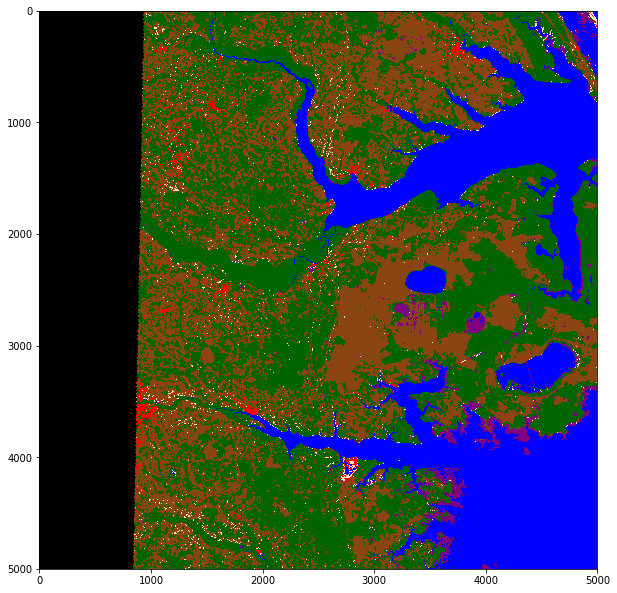

In [27]:
from matplotlib import colors

# Build a listed colormap.
c_map = colors.ListedColormap(['black', 'blue', 'red', 'darkgreen', 'saddlebrown', 'bisque', 'purple'])
bounds = [-1, 0, 1, 2, 3,4,5,6]
norm = colors.BoundaryNorm(bounds, c_map.N)

fig, axs = plt.subplots(figsize=(10,12))

# Plot the image with a color bar
axs = plt.imshow(prediction_array, cmap=c_map, norm=norm)

In [28]:
img_fp = img_name + '.tif'

# Read metadata of first file and assume all other bands are the same

meta = landsat_datasets[tile][0].meta
# Update metadata to reflect the number of layers
meta.update(count = 1) #add 1 because ndvi
# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    dst.write_band(1, prediction_array.astype(np.int16))

In [29]:
img_fp

'rcnn_028011_1989.tif'

In [38]:
# prediction_array_028012 = prediction_array